# Fraud Detection
The training examples are vectors in a multidimensional feature space, each with a class label. The training phase of the algorithm consists only of storing the feature vectors and class labels of the training samples.

In the classification phase, k is a user-defined constant, and an unlabeled vector (a query or test point) is classified by assigning the label which is most frequent among the k training samples nearest to that query point. 

My modifications:

* Created new 'Label' column for fraud<br>
* Applied the first rule, fraud is found as total calls over a 15-minute period from a single number<br>
* Second Rule states that fixed number of daily calls from a single number<br>
* Create an aggregate array grouping each set by it’s 15 minute time interval (see the CDRs for the format of such - averages such as CPM/RPM need to be averaged in the aggregate, the booleans like answered need to be counted, and the numerical values like cost/revenue need to be summed)<br>
* Run project 2 for the buckets and see what the best accuracy you can come up with for buckets that contain some number of fraud cases.<br>
* Save whatever your best accuracy test is (try tinkering with the parameters like project 2, your accuracy is both % of * Save all CDRs that belong to buckets that your P2 found to be fraud into a single file <br>

In [2]:
import warnings
warnings.filterwarnings('ignore')

#for data preprocessing 
import pandas as pd
import numpy as np
from sklearn import preprocessing

#for differnt classifier for testing 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BaseNB


#for validation 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

#for visualization
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import itertools
scaler = StandardScaler()

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
data_threshold = 10000

In [5]:
df = pd.read_csv('fraud_analysis.csv')
df.head()

,Unnamed: 0,CPM_mean,RPM_mean,Answered_count,Cost_sum,Revenue_sum,Count
0,0,0.05933,0.000000,1,4.91,0.00,1
1,1,0.05933,0.063045,1,0.88,0.94,1
2,2,0.05933,0.000000,1,0.20,0.00,1
3,3,0.05933,0.000000,1,1.44,0.00,1
4,4,0.05933,0.000000,1,3.55,0.00,1


In [6]:
df = df.drop(df.columns[0], axis=1)
df.head()

,CPM_mean,RPM_mean,Answered_count,Cost_sum,Revenue_sum,Count
0,0.05933,0.000000,1,4.91,0.00,1
1,0.05933,0.063045,1,0.88,0.94,1
2,0.05933,0.000000,1,0.20,0.00,1
3,0.05933,0.000000,1,1.44,0.00,1
4,0.05933,0.000000,1,3.55,0.00,1


### Add label column

In [7]:
df['Label'] = 0
df.head()

,CPM_mean,RPM_mean,Answered_count,Cost_sum,Revenue_sum,Count,Label
0,0.05933,0.000000,1,4.91,0.00,1,0
1,0.05933,0.063045,1,0.88,0.94,1,0
2,0.05933,0.000000,1,0.20,0.00,1,0
3,0.05933,0.000000,1,1.44,0.00,1,0
4,0.05933,0.000000,1,3.55,0.00,1,0


In [8]:
df2 = pd.read_csv('complete_data.csv')
df2.head()

,Unnamed: 0,CallStartTime,CallingNumber,CalledNumber,OrigTrunk,TermTrunk,CallDuration,CallConnectTime,FaultCode,Answered,...,TermAcc,RouteClass,OrigCountry,TermCountry,Destination,Cost,Revenue,CPM,RPM,CDRArrivalTime
0,4,2019-04-02 08:57:00,3.110409e+10,448444737373,IVC.DERAT1SB83-TELE2.4,IVC.UKLON8SB01-VF.UKF.MA5,4967,2019-04-02 08:57:00,100.0,1,...,Vodafone UK Fixed Line,Hubbing Gold,Netherlands,UK,"UK,Local Call Plus",4.91,0.00,0.05933,0.000000,2019-04-02 11:19:00
1,0,2019-04-02 08:57:56,3.161505e+10,448444737373,IVC.ESMAD7SB22-VF.NL.1,IVC.UKLON8SB01-VF.UKF.CS9,891,2019-04-02 08:57:56,100.0,1,...,Vodafone UK Fixed Line,Retail Gold,Netherlands,UK,"UK,Local Call Plus",0.88,0.94,0.05933,0.063045,2019-04-02 10:05:00
2,1,2019-04-02 08:58:07,2.542043e+11,448444737373,IVC.ESMAD7SB34-ORG.PP.2,IVC.UKLON8SB01-VF.UKF.SQ9,203,2019-04-02 08:58:07,100.0,1,...,Vodafone UK Fixed Line,Hubbing Gold,Kenya,UK,"UK,Local Call Plus",0.20,0.00,0.05933,0.000000,2019-04-02 10:05:00
3,2,2019-04-02 08:59:33,3.349377e+10,448444737373,IVC.DERAT1SB59-ORG.PP.1,IVC.DERAT1SB61-VF.UKF.SQ9,1461,2019-04-02 08:59:33,100.0,1,...,Vodafone UK Fixed Line,Hubbing Gold,France,UK,"UK,Local Call Plus",1.44,0.00,0.05933,0.000000,2019-04-02 10:19:00
4,3,2019-04-02 08:59:35,4.685062e+10,448444737373,IVC.DERAT1SB83-TELE2.3,IVC.ESMAD7SB20-VF.UKF.CS9,3592,2019-04-02 08:59:36,100.0,1,...,Vodafone UK Fixed Line,Hubbing Gold,Sweden,UK,"UK,Local Call Plus",3.55,0.00,0.05933,0.000000,2019-04-02 15:35:00


In [9]:
df2 = df2.drop(df2.columns[0], axis=1)

In [10]:
df2.head()

,CallStartTime,CallingNumber,CalledNumber,OrigTrunk,TermTrunk,CallDuration,CallConnectTime,FaultCode,Answered,Seized,...,TermAcc,RouteClass,OrigCountry,TermCountry,Destination,Cost,Revenue,CPM,RPM,CDRArrivalTime
0,2019-04-02 08:57:00,3.110409e+10,448444737373,IVC.DERAT1SB83-TELE2.4,IVC.UKLON8SB01-VF.UKF.MA5,4967,2019-04-02 08:57:00,100.0,1,1,...,Vodafone UK Fixed Line,Hubbing Gold,Netherlands,UK,"UK,Local Call Plus",4.91,0.00,0.05933,0.000000,2019-04-02 11:19:00
1,2019-04-02 08:57:56,3.161505e+10,448444737373,IVC.ESMAD7SB22-VF.NL.1,IVC.UKLON8SB01-VF.UKF.CS9,891,2019-04-02 08:57:56,100.0,1,1,...,Vodafone UK Fixed Line,Retail Gold,Netherlands,UK,"UK,Local Call Plus",0.88,0.94,0.05933,0.063045,2019-04-02 10:05:00
2,2019-04-02 08:58:07,2.542043e+11,448444737373,IVC.ESMAD7SB34-ORG.PP.2,IVC.UKLON8SB01-VF.UKF.SQ9,203,2019-04-02 08:58:07,100.0,1,1,...,Vodafone UK Fixed Line,Hubbing Gold,Kenya,UK,"UK,Local Call Plus",0.20,0.00,0.05933,0.000000,2019-04-02 10:05:00
3,2019-04-02 08:59:33,3.349377e+10,448444737373,IVC.DERAT1SB59-ORG.PP.1,IVC.DERAT1SB61-VF.UKF.SQ9,1461,2019-04-02 08:59:33,100.0,1,1,...,Vodafone UK Fixed Line,Hubbing Gold,France,UK,"UK,Local Call Plus",1.44,0.00,0.05933,0.000000,2019-04-02 10:19:00
4,2019-04-02 08:59:35,4.685062e+10,448444737373,IVC.DERAT1SB83-TELE2.3,IVC.ESMAD7SB20-VF.UKF.CS9,3592,2019-04-02 08:59:36,100.0,1,1,...,Vodafone UK Fixed Line,Hubbing Gold,Sweden,UK,"UK,Local Call Plus",3.55,0.00,0.05933,0.000000,2019-04-02 15:35:00


### Rule 1: Set threshold to total calls over a 15-minute period from a single number

In [11]:
def label_func(row):
    th_15_min = 1
    val = 0
    if row['Count'] > th_15_min:
        val = 1
        
    return val

In [12]:
df.Label = df.apply(label_func, axis=1)
df.head()

,CPM_mean,RPM_mean,Answered_count,Cost_sum,Revenue_sum,Count,Label
0,0.05933,0.000000,1,4.91,0.00,1,0
1,0.05933,0.063045,1,0.88,0.94,1,0
2,0.05933,0.000000,1,0.20,0.00,1,0
3,0.05933,0.000000,1,1.44,0.00,1,0
4,0.05933,0.000000,1,3.55,0.00,1,0


### Rule 2: 900 daily calls from a single number

In [13]:
th_total_calls = 900

In [14]:
df3 = df2.copy()

In [15]:
df3.CallStartTime = pd.to_datetime(df3.CallStartTime)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74280 entries, 0 to 74279
Data columns (total 22 columns):
CallStartTime      74280 non-null datetime64[ns]
CallingNumber      74278 non-null float64
CalledNumber       74280 non-null int64
OrigTrunk          74280 non-null object
TermTrunk          74166 non-null object
CallDuration       74280 non-null int64
CallConnectTime    74280 non-null object
FaultCode          74175 non-null float64
Answered           74280 non-null int64
Seized             74280 non-null int64
Minutes            74280 non-null float64
OrigAcc            74280 non-null object
TermAcc            74280 non-null object
RouteClass         74280 non-null object
OrigCountry        73776 non-null object
TermCountry        74280 non-null object
Destination        74280 non-null object
Cost               74280 non-null float64
Revenue            74280 non-null float64
CPM                74280 non-null float64
RPM                74280 non-null float64
CDRArrivalTime     

### Find total calls daily

In [16]:
df3_15 = df3.resample('D', on='CallStartTime').count()
df3_15

,CallStartTime,CallingNumber,CalledNumber,OrigTrunk,TermTrunk,CallDuration,CallConnectTime,FaultCode,Answered,Seized,...,TermAcc,RouteClass,OrigCountry,TermCountry,Destination,Cost,Revenue,CPM,RPM,CDRArrivalTime
CallStartTime,,,,,,,,,,,,,,,,,,,,,
2019-04-02,187,187,187,187,187,187,187,187,187,187,...,187,187,187,187,187,187,187,187,187,187
2019-04-03,4053,4053,4053,4053,4053,4053,4053,4053,4053,4053,...,4053,4053,4053,4053,4053,4053,4053,4053,4053,4053
2019-04-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-04-05,36265,36263,36265,36265,36159,36265,36265,36167,36265,36265,...,36265,36265,36093,36265,36265,36265,36265,36265,36265,36265
2019-04-06,30530,30530,30530,30530,30522,30530,30530,30523,30530,30530,...,30530,30530,30198,30530,30530,30530,30530,30530,30530,30530
2019-04-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-04-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-04-09,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,...,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580
2019-04-10,1521,1521,1521,1521,1521,1521,1521,1521,1521,1521,...,1521,1521,1521,1521,1521,1521,1521,1521,1521,1521


In [17]:
def foo(date):
    start_date = date
    end_date = pd.to_datetime(date + pd.to_timedelta('1 day'))
    mask = (df3['CallStartTime'] > start_date) & (df3['CallStartTime'] < end_date)
    temp = df3.loc[mask]
    
    return temp.groupby('CallingNumber', as_index=False).size()

### Collect the most suspicious dates (th > 900)

In [18]:
nums_daily_calls = []
dates = []
for i in range(df3_15.shape[0]):
    if(df3_15.iloc[i]['CallingNumber'] > th_total_calls):
        dates.append(df3_15.index[i])
dates

[Timestamp('2019-04-03 00:00:00', freq='D'),
 Timestamp('2019-04-05 00:00:00', freq='D'),
 Timestamp('2019-04-06 00:00:00', freq='D'),
 Timestamp('2019-04-09 00:00:00', freq='D'),
 Timestamp('2019-04-10 00:00:00', freq='D')]

In [19]:
for date in dates:
    blah = foo(pd.to_datetime(date))
    if blah[blah.argmax()] > th_total_calls:
        nums_daily_calls.append(blah.argmax())

In [20]:
nums_daily_calls

[441291440500.0, 390230031880.0, 390230031880.0]

### Update df DataFrame with features and targets

In [21]:
df4 = df2.copy()
df_new = df.copy()

In [22]:
df_new['CallingNumber'] = df4.CallingNumber[0:df_new.shape[0]]
df_new.tail()

,CPM_mean,RPM_mean,Answered_count,Cost_sum,Revenue_sum,Count,Label,CallingNumber
29993,0.018881,0.020723,1,0.01,0.01,1,0,1.973285e+10
29994,0.018881,0.021389,1,0.01,0.01,1,0,6.493683e+09
29995,0.018881,0.020723,1,0.02,0.02,1,0,6.493680e+09
29996,0.018881,0.020723,1,0.00,0.00,1,0,1.612722e+10
29997,0.000000,0.000000,0,0.00,0.00,1,0,6.493687e+09


In [23]:
def update_label_call_num(row):
    val = row['Label']
    if row['CallingNumber'] in nums_daily_calls:
        val = 1
    
    return val

In [24]:
df_new['Label'] = df_new.apply(update_label_call_num, axis=1)

In [25]:
del df_new['CallingNumber']

### Train Data

In [26]:
df_new.head(10)

,CPM_mean,RPM_mean,Answered_count,Cost_sum,Revenue_sum,Count,Label
0,0.05933,0.000000,1,4.91,0.00,1,0.0
1,0.05933,0.063045,1,0.88,0.94,1,0.0
2,0.05933,0.000000,1,0.20,0.00,1,0.0
3,0.05933,0.000000,1,1.44,0.00,1,0.0
4,0.05933,0.000000,1,3.55,0.00,1,0.0
5,0.05933,0.000000,2,1.47,0.00,2,1.0
6,0.05933,0.063045,1,1.23,1.30,1,0.0
7,0.05933,0.000000,1,1.14,0.00,1,0.0
8,0.05933,0.079706,1,1.22,1.63,1,0.0
9,0.05933,0.079706,4,4.82,6.48,4,1.0


# Training and testing data

In [41]:
x = df_new[['CPM_mean', 'RPM_mean', 'Answered_count', 'Cost_sum', 'Revenue_sum', 'Count']]
y = df_new['Label']

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.5, random_state=0)

res = []

## K Neighbors Classifier

k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The k-NN algorithm is among the simplest of all machine learning algorithms.<br><br>

Both for classification and regression, a useful technique can be used to assign weight to the contributions of the neighbors, so that the nearer neighbors contribute more to the average than the more distant ones. For example, a common weighting scheme consists in giving each neighbor a weight of 1/d, where d is the distance to the neighbor.
<img src="knn.gif">

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8780
         1.0       1.00      1.00      1.00      6219

   micro avg       1.00      1.00      1.00     14999
   macro avg       1.00      1.00      1.00     14999
weighted avg       1.00      1.00      1.00     14999



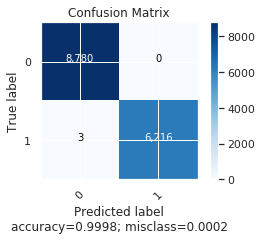

In [42]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(x_train,y_train)
score = clf_knn.score(x_test,y_test)
y_pred = clf_knn.predict(x_test)
print(classification_report(y_test, y_pred))
x = classification_report(y_test, y_pred)
res.append(['KNN',x.split()[-2]])
# # confusion_matrix
plot_confusion_matrix(cm = confusion_matrix(y_test, y_pred), 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title= "Confusion Matrix")

## Decision Tree Classifier

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.<br><br>

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning. 
<br><br>
Basic Model:
<img src = "decision-tree.png">

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8780
         1.0       1.00      1.00      1.00      6219

   micro avg       1.00      1.00      1.00     14999
   macro avg       1.00      1.00      1.00     14999
weighted avg       1.00      1.00      1.00     14999



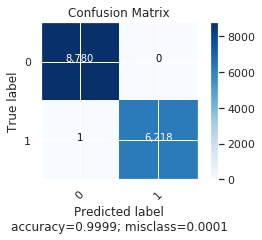

In [43]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(x_train,y_train)
score = clf_dt.score(x_test,y_test)
y_pred = clf_dt.predict(x_test)
print(classification_report(y_test, y_pred))
x = classification_report(y_test, y_pred)
res.append(['dec-tree',x.split()[-2]])
# # confusion_matrix
plot_confusion_matrix(cm = confusion_matrix(y_test, y_pred), 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title= "Confusion Matrix")

## Neural Network - MLP
A **multilayer perceptron (MLP)** is a class of feedforward artificial neural network. A MLP consists of, at least, three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.
<br>
Multilayer perceptrons are sometimes colloquially referred to as "vanilla" neural networks, especially when they have a single hidden layer.
<img src = "mlp-network.png">

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8780
         1.0       1.00      1.00      1.00      6219

   micro avg       1.00      1.00      1.00     14999
   macro avg       1.00      1.00      1.00     14999
weighted avg       1.00      1.00      1.00     14999



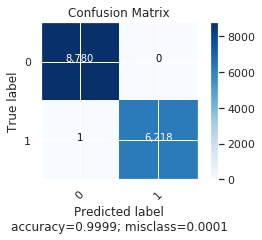

In [44]:
clf_mpl = MLPClassifier()
clf_mpl.fit(x_train,y_train)
score = clf_mpl.score(x_test,y_test)

y_pred = clf_mpl.predict(x_test)
print(classification_report(y_test, y_pred))
x = classification_report(y_test, y_pred)
res.append(['Neural_network',x.split()[-2]])

# confusion_matrix
plot_confusion_matrix(cm = confusion_matrix(y_test, y_pred), 
                      normalize    = False,
                      target_names =   ['0', '1'],
                      title= "Confusion Matrix")

In [45]:
res = [[x,float(str(y))] for x,y in res]

In [46]:
f1_score = pd.DataFrame(res,columns=['Classifier','f1-score'])

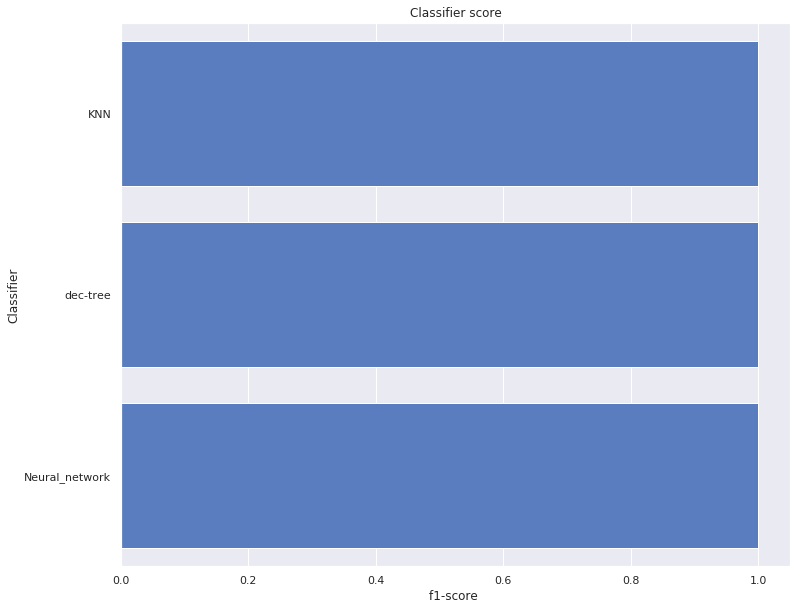

In [47]:
plt.figure(figsize=(12,10))
sns.set_color_codes("muted")
sns.barplot(x='f1-score', y='Classifier', data=f1_score, color="b")

plt.xlabel('f1-score ')
plt.title('Classifier score')
plt.show()